# Machine Learning with Scikit-Learn
The objective is to develop regression machine learning models that predict the total number of people affected by natural disaster based on various input features.  It is important to note that this dataset was not originally intended for building regression machine learning models. However, for learning purposes, we have created supervised regression machine learning models by randomly selecting a target variable from the datatset. 

The following machine learning models were trained on the dataset.

- Linear regression

- Support vector machine regressor

- Random forest regressor

- XGBoost regressor

- LGBM regressor

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

plt.rcParams.update({'font.size': 18})

In [2]:
# Import custom class
%run -i '../src/1-transfxn.py'
%run -i '../src/2-ml.py'

In [3]:
# Instantiate the  classes
transf_pipeline = TransformationPipeline()
model = RegressionML()

# Load data

In [4]:
df = pd.read_csv('../data/ml_data.csv') 
print("Data size:", df.shape)
df.columns = [x.lower() for x in df.columns]
df.head()

Data size: (16338, 28)


,iso,country,region,continent,year,disaster_type,latitude,longitude,local_time,start_month,...,year_in_decade,no_occurrence,contnt_ct,disaster_ty_ct,country_ct,no_affected_per_occur,no_affected_per_contnt,no_affected_per_cntry,no_affected_per_ty,flood_storm_ind
0,CPV,Cabo Verde,Western Africa,Africa,1900,Drought,NaN,NaN,NaN,NaN,...,1900,7.0,2986,779,23,0.0,0.0,0.0,0.0,N
1,IND,India,Southern Asia,Asia,1900,Drought,NaN,NaN,NaN,NaN,...,1900,7.0,6568,779,758,0.0,0.0,0.0,0.0,N
2,GTM,Guatemala,Central America,Americas,1902,Earthquake,14.0,-91.0,20:20,4.0,...,1900,10.0,4029,1561,122,0.0,0.0,0.0,0.0,N
3,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,NaN,4.0,...,1900,10.0,4029,270,122,0.0,0.0,0.0,0.0,N
4,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,NaN,10.0,...,1900,10.0,4029,270,122,0.0,0.0,0.0,0.0,N


# Data types & missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16338 entries, 0 to 16337
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso                       16338 non-null  object 
 1   country                   16338 non-null  object 
 2   region                    16338 non-null  object 
 3   continent                 16338 non-null  object 
 4   year                      16338 non-null  int64  
 5   disaster_type             16338 non-null  object 
 6   latitude                  2739 non-null   float64
 7   longitude                 2739 non-null   float64
 8   local_time                1118 non-null   object 
 9   start_month               15949 non-null  float64
 10  total_deaths              16338 non-null  float64
 11  no_injured                16338 non-null  float64
 12  no_affected               16338 non-null  float64
 13  no_homeless               16338 non-null  float64
 14  total_

In [6]:
 # Convert start month variable to string
param_dict = {
    1:'Jan', 2:'Feb', 3:'Mar', 
    4:'Apr', 5:'May', 6:'Jun', 
    7:'Jul', 8:'Aug', 9:'Sep', 
    10:'Oct', 11:'Nov', 12:'Dec',
}
 df['start_month'].replace(param_dict, inplace=True)

# Distribution of the target variable

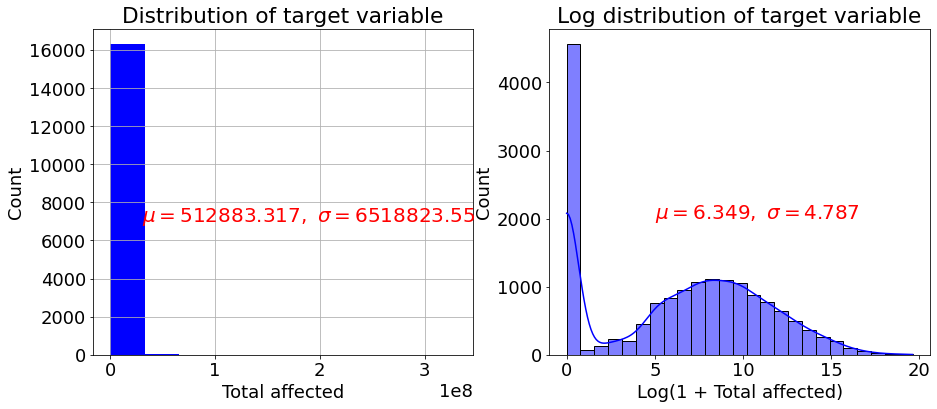

In [7]:
# Log(1+x) transformation
df['log_total_affected'] = np.log1p(df['total_affected'])  

# Mean and std of the target variable
mu1 = np.round(df['total_affected'].mean(),3)
mu2 = np.round(df['log_total_affected'].mean(),3)
sigma1 = np.round(df['total_affected'].std(),3)
sigma2 = np.round(df['log_total_affected'].std(),3)

# Plot distributions
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
df['total_affected'].hist(color='b', ax=ax1)
sns.histplot(df['log_total_affected'], kde=True, color='b', ax=ax2)

ax1.set_xlabel('Total affected')
ax1.set_ylabel('Count')
ax1.set_title("Distribution of target variable")
ax1.text(0.3*10**8, 7000, f'$\mu = {mu1},~ \sigma = {sigma1}$', color='r', fontsize=20)
ax2.text(5, 2000, f'$\mu = {mu2},~ \sigma = {sigma2}$', color='r', fontsize=20)
ax2.set_xlabel('Log(1 + Total affected)')
ax2.set_title("Log distribution of target variable")
plt.show()

# Feature matrix and target variable

In [8]:
# List to drop
drop_cols = [
    'iso', 'country', 'region', 
    'year_in_decade', 'longitude', 
    'latitude', 'log_total_affected', 
    'total_affected', 'local_time', 
    'local_hour', 'disaster_type',
]
# Create feature matrix and target variable
X, y = df.drop(drop_cols, axis=1), df['log_total_affected']

# Create a test set
Create $80\%$ training set and $20\%$ test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
print(f'Training set size: {X_train.shape, y_train.shape}')
print(f'Test set size: {X_test.shape, y_test.shape}')

Training set size: ((13070, 18), (13070,))
Test set size: ((3268, 18), (3268,))


# Data preprocessing

In [11]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_nm = transf_pipeline.preprocessing(X_train, X_test)

In [12]:
print(f'Training set size after pre-processing: {X_train_scaled.shape}')
print(f'Test set size after pre-processing: { X_test_scaled.shape}')

Training set size after pre-processing: (13070, 34)
Test set size after pre-processing: (3268, 34)


In [13]:
# Convert the class labels to arrays
y_train, y_test = y_train.values, y_test.values

# Model Training

## A. Linear Regression

In [14]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Training set prediction
model.eval_metrics(lr.predict(X_train_scaled), y_train, 
                   subset='training set',
                   model_nm='Linear regression',
                  )

Prediction on the training set for Linear regression
---------------------------------------------
{'MAE': 1.187, 'RMSE': 1.678, 'R^2': 0.877}
---------------------------------------------


## A-1. Cross-validation for Linear Regression

In [15]:
model.eval_metric_cv(lr, X_train_scaled, y_train, cv_fold=10, model_nm='Linear regression')

10-Fold cross-validation results for Linear regression
---------------------------------------------
{'MAE': 1.191, 'RMSE': 1.682, 'R^2': 0.877}
---------------------------------------------


## B. Support Vector Regressor

In [16]:
svr = SVR()
svr.fit(X_train_scaled, y_train)

# Training set prediction
model.eval_metrics(svr.predict(X_train_scaled), y_train, 
                   subset='training set', 
                   model_nm='SVM regressor',
                  )

Prediction on the training set for SVM regressor
---------------------------------------------
{'MAE': 0.256, 'RMSE': 0.642, 'R^2': 0.982}
---------------------------------------------


## B-1. Cross-validation for Support Vector Regressor

In [17]:
model.eval_metric_cv(svr, X_train_scaled, y_train, cv_fold=10, model_nm='SVM regressor')

10-Fold cross-validation results for SVM regressor
---------------------------------------------
{'MAE': 0.29, 'RMSE': 0.69, 'R^2': 0.979}
---------------------------------------------


In [18]:
# Plot MAE and RMSE with different hyperparamters
# model.plot_mae_rsme_svr(X_train_scaled, y_train, cv_fold=10)

## B-2. Hyperparameter Optimization for SVR
We now optimize the MAE of Support vector regressor using randomized search

In [19]:
# Range of hyperparameters
params = {
    'C': [2**x for x in range(-2,11,2)], 
    'gamma': [2**x for x in range(-11,1,2)],
} 
                                                              
# Randomized search for SVR
rsearch_svr = RandomizedSearchCV(
    estimator=SVR(), 
    param_distributions=params, 
    scoring='neg_mean_absolute_error',
    n_iter=200, 
    cv=10, 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
) 
# Fit the training set
rsearch_svr.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svr.best_estimator_, '../data/svr.pkl')

print('Best MAE score:', -rsearch_svr.best_score_)
print('Best parameters:', rsearch_svr.best_params_)  

Fitting 10 folds for each of 42 candidates, totalling 420 fits
Best MAE score: 0.23667700579563067
Best parameters: {'gamma': 0.0078125, 'C': 1024}


## C. Random Forest Regressor

In [18]:
rf = RandomForestRegressor(random_state=42) 
rf.fit(X_train_scaled, y_train)

# Training set prediction
model.eval_metrics(rf.predict(X_train_scaled), y_train, 
                   subset='training set',
                   model_nm='Random forest regressor')

Prediction on the training set for Random forest regressor
---------------------------------------------
{'MAE': 0.005, 'RMSE': 0.024, 'R^2': 1.0}
---------------------------------------------


## C-1. Cross-validation for Random Forest Regressor

In [19]:
model.eval_metric_cv(rf, X_train_scaled, y_train, cv_fold=10, model_nm='Random forest regressor')

10-Fold cross-validation results for Random forest regressor
---------------------------------------------
{'MAE': 0.013, 'RMSE': 0.066, 'R^2': 1.0}
---------------------------------------------


## C-2. Feature Importances for Random Forest Regressor

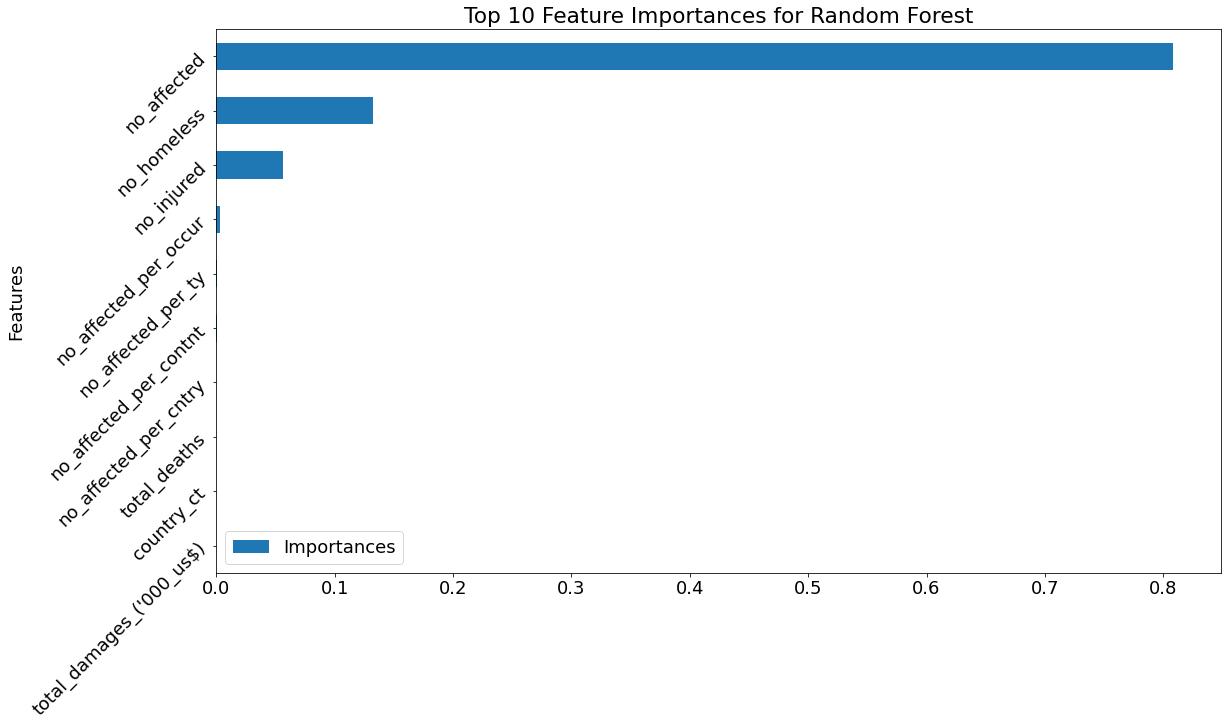

In [22]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_nm, 
    'Importances': rf.feature_importances_,
    }
)

# Plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(10).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for Random Forest')
plt.savefig('../img/rf.png')

## C-3. Hyperparameter Optimization for Ramdom Forest Regressor
We now optimize the MAE of Random forest regressor using randomized search

In [23]:
# Hyperparameter range
params = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': range(2,10,1),
    'bootstrap': [True, False],
}

# Randomized search
rf =  RandomForestRegressor(n_estimators=1000, random_state=42)                       
rsearch_rf = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=params, 
    scoring='neg_mean_absolute_error',
    cv=10, 
    n_iter=200,
    n_jobs=-1,
    random_state=42, 
    verbose=1
)  
# Fit model
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../data/rf.pkl')

# Print results
print('Best MAE score:', -rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 192 candidates, totalling 1920 fits
Best MAE score: 0.01293004460955174
Best hyperparameters: {'min_samples_split': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


## D. XGBoost

In [20]:
xgbm = xgb.XGBRegressor(random_state=42)
xgbm.fit(X_train_scaled, y_train)

# Training set prediction
model.eval_metrics(xgbm.predict(X_train_scaled), y_train, 
                   subset='training set',
                   model_nm='XGBoost regressor',
                  )

Prediction on the training set for XGBoost regressor
---------------------------------------------
{'MAE': 0.011, 'RMSE': 0.019, 'R^2': 1.0}
---------------------------------------------


## D-1. Cross-validation for XGBoost Regressor

In [21]:
model.eval_metric_cv(xgbm, X_train_scaled, y_train, cv_fold=10, model_nm='XGBoost regressor')

10-Fold cross-validation results for XGBoost regressor
---------------------------------------------
{'MAE': 0.022, 'RMSE': 0.059, 'R^2': 1.0}
---------------------------------------------


## D-2. Feature Importances for XGBoost Regressor

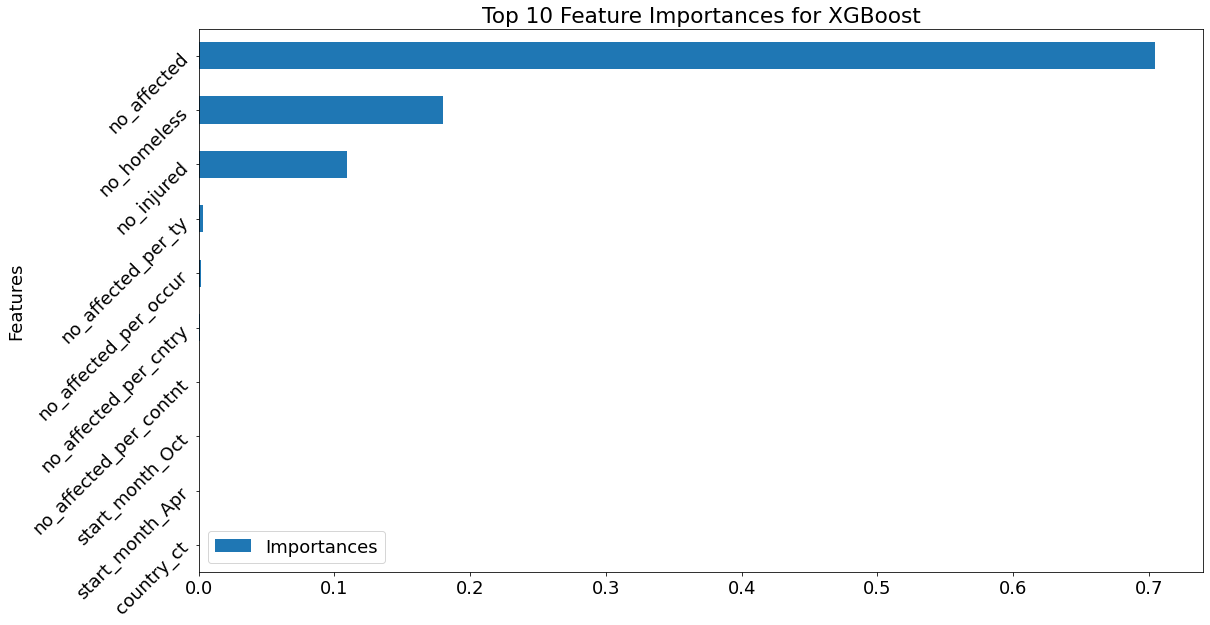

In [26]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_nm, 
    'Importances': xgbm.feature_importances_,
    }
)

# Plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(10).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for XGBoost')
plt.savefig('../img/xgbm.png')

## D-3. Hyperparameter Optimization for XGBoost
We now optimize the MAE of XGBoost regressor using randomized search

In [27]:
# Hyperparameter range
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          }

# Randomized search
param_dist = {
    'objective':'reg:squarederror', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':1000,
}
xgbm =  xgb.XGBRegressor(**param_dist)                       
rsearch_xgbm = RandomizedSearchCV(
    estimator=xgbm, 
    param_distributions=params, 
    n_iter=200,
    scoring='neg_mean_absolute_error',
    cv=10, 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)  
# Fit model
rsearch_xgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgbm.best_estimator_, '../data/xgbm.pkl')

# Print results
print('Best MAE score:', -rsearch_xgbm.best_score_) 
print('Best hyperparameters:', rsearch_xgbm.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best MAE score: 0.024098110840169638
Best hyperparameters: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 0.0, 'colsample_bytree': 0.8}


## E. LGBM Regressor

In [22]:
lgbm = lgb.LGBMRegressor(random_state=42)
lgbm.fit(X_train_scaled, y_train)

# Training set prediction
model.eval_metrics(lgbm.predict(X_train_scaled), y_train, 
                   subset='training set',
                   model_nm='LGBM regressor',
                  )

Prediction on the training set for LGBM regressor
---------------------------------------------
{'MAE': 0.018, 'RMSE': 0.047, 'R^2': 1.0}
---------------------------------------------


## E-1. Cross-validation for LGBM Regressor

In [23]:
model.eval_metric_cv(lgbm, X_train_scaled, y_train, cv_fold=10, model_nm='LGBM regressor')

10-Fold cross-validation results for LGBM regressor
---------------------------------------------
{'MAE': 0.022, 'RMSE': 0.07, 'R^2': 1.0}
---------------------------------------------


## E-2. Feature Importances for LGBM Regressor

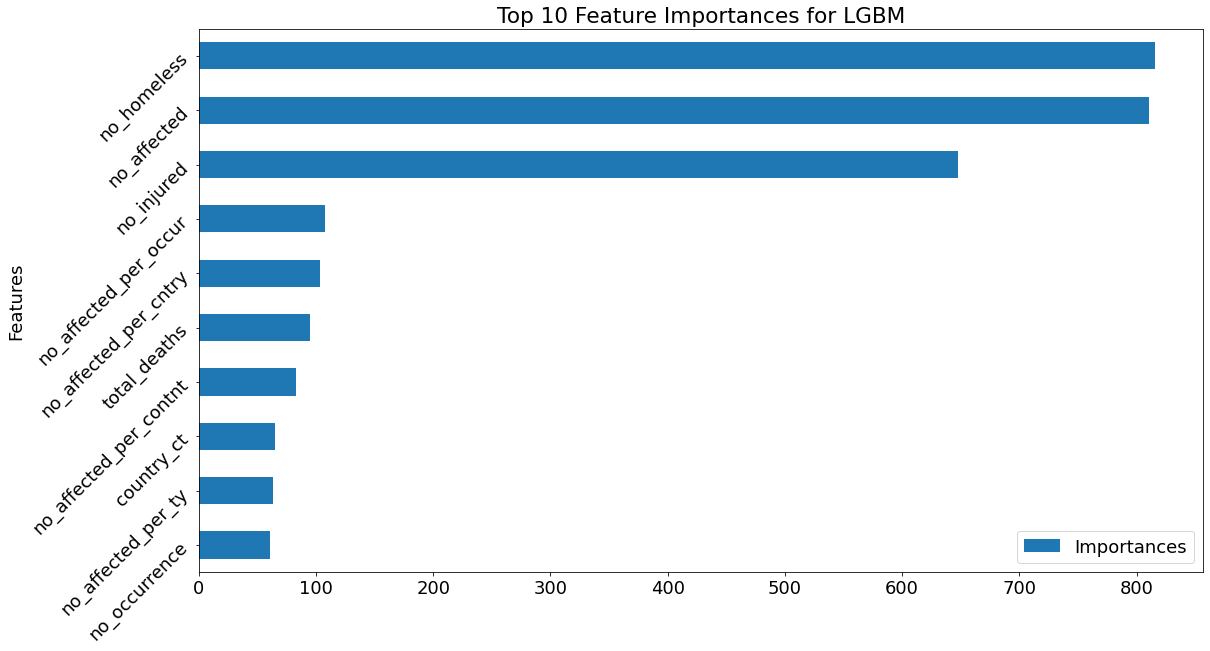

In [30]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_nm, 
    'Importances': lgbm.feature_importances_,
    }
)

# Plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(10).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for LGBM')
plt.savefig('../img/lgbm.png')

## E-3. Hyperparameter Optimization for LGBM
We now optimize the MAE of LGBM regressor using randomized search

In [31]:
# Hyperparameter range
params = {
    'max_depth': [10, 20, 30],
    'num_leaves': range(90,120,5),
    'min_child_samples': range(20,50,10),
}

# Randomized search
lgbm =  lgb.LGBMRegressor(n_estimators=1000, random_state=42)                       
rsearch_lgbm = RandomizedSearchCV(
    estimator=lgbm, 
    param_distributions=params, 
    n_iter=200,
    scoring='neg_mean_absolute_error',
    cv=10, 
    n_jobs=-1, 
    random_state=42, 
    verbose=1
)  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../data/lgbm.pkl')

# Print results
print('Best MAE score:', -rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best MAE score: 0.021900858039022895
Best hyperparameters: {'num_leaves': 90, 'min_child_samples': 20, 'max_depth': 10}


# Model Selection
The results show that Random Forest Regressor slightly outperformed other models.

In [24]:
# Load trained model
svr = joblib.load('../data/svr.pkl')
rf = joblib.load('../data/rf.pkl')
lgbm = joblib.load('../data/lgbm.pkl')
xgbm = joblib.load('../data/xgbm.pkl')

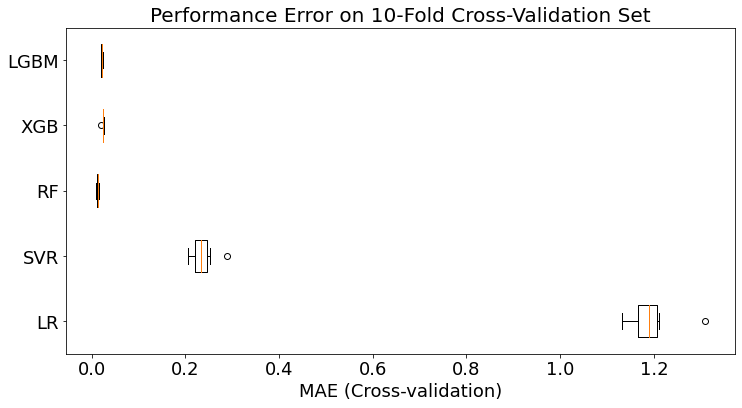

In [33]:
model_dict = {
    'LR': lr, 
    'SVR': svr, 
    'RF': rf,  
    'XGB': xgbm, 
    'LGBM': lgbm,
}
mae_scores = []
for i, (name, model) in enumerate(model_dict.items()):
    score = cross_val_score(
        model, 
        X_train_scaled, 
        y_train, 
        cv=10, 
        scoring='neg_mean_absolute_error',
    )
    mae_scores.append(-score)

plt.figure(figsize=(12,6))
plt.boxplot(mae_scores, vert=False)
plt.yticks(np.arange(len(model_dict)) + 1, list(model_dict.keys()))
plt.xlabel('MAE (Cross-validation)')
plt.title('Performance Error on 10-Fold Cross-Validation Set', fontsize=20)
plt.savefig('../img/cv_error2.png')
plt.show()

# Test Predictions

# A. Random Forest Regressor

In [25]:
model.eval_metrics(rf.predict(X_test_scaled), y_test, 
                   subset='test set',
                   model_nm='Random forest regressor',
                  )

Prediction on the test set for Random forest regressor
---------------------------------------------
{'MAE': 0.013, 'RMSE': 0.06, 'R^2': 1.0}
---------------------------------------------


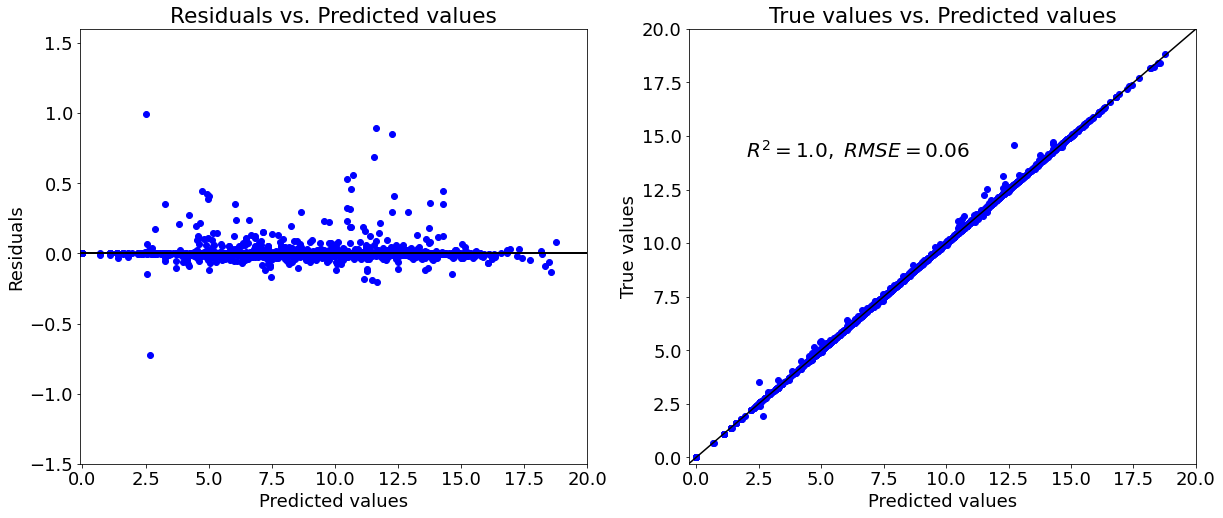

In [35]:
model.diagnostic_plot(rf.predict(X_test_scaled), y_test, ylim=[-1.5, 1.6])

# B. XGBoost Regressor

In [26]:
model.eval_metrics(xgbm.predict(X_test_scaled), y_test, 
                   subset='test set',
                   model_nm='XGBoost regressor',
                  )

Prediction on the test set for XGBoost regressor
---------------------------------------------
{'MAE': 0.023, 'RMSE': 0.049, 'R^2': 1.0}
---------------------------------------------


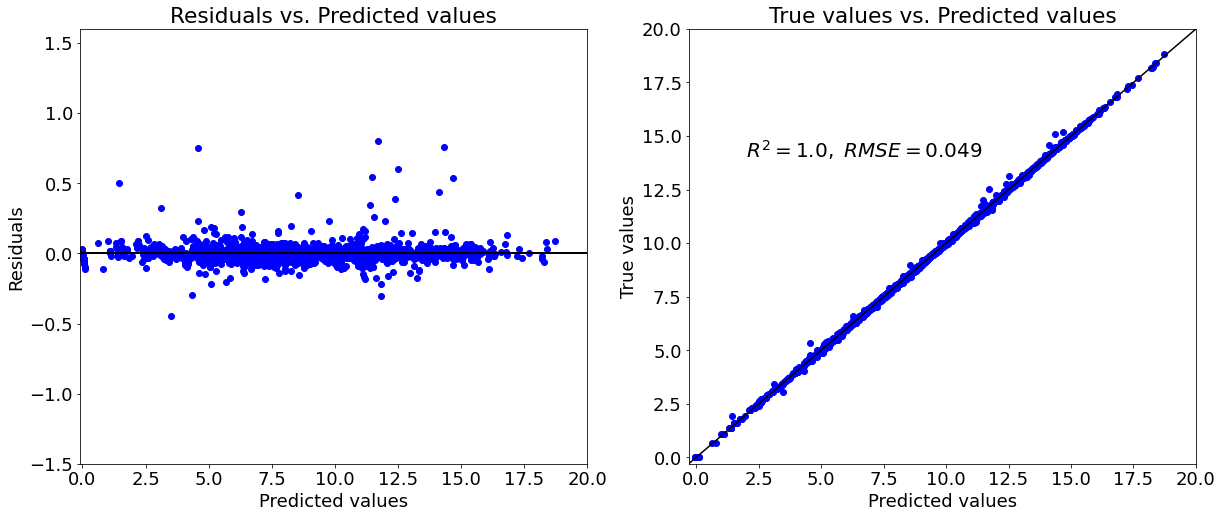

In [37]:
model.diagnostic_plot(xgbm.predict(X_test_scaled), y_test, ylim=[-1.5, 1.6])

# C. LGBM Regressor

In [27]:
model.eval_metrics(lgbm.predict(X_test_scaled), y_test, 
                   subset='test set',
                   model_nm='LGBM regressor',
                  )

Prediction on the test set for LGBM regressor
---------------------------------------------
{'MAE': 0.023, 'RMSE': 0.069, 'R^2': 1.0}
---------------------------------------------


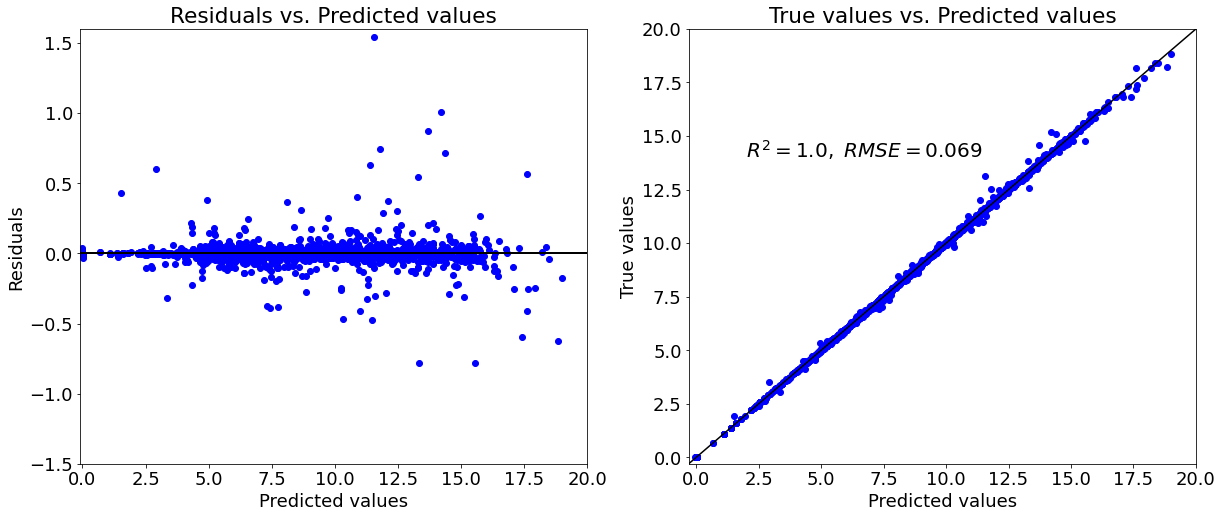

In [39]:
model.diagnostic_plot(lgbm.predict(X_test_scaled), y_test, ylim=[-1.5, 1.6])